In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [7]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] )  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print(" " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


def check_model(trained_model, model_name):
    pred = trained_model.predict(X_validation)
    pred = pd.DataFrame(data=pred.flatten())
    hist = pred[0].value_counts(normalize=True) * 100
    print("classification report of {}:".format(model_name))
    print(classification_report(y_validation, pred))
    cm = confusion_matrix(y_validation, pred)
    np.set_printoptions(precision=2)
    class_names = np.unique(y_validation.values)
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_validation, pred, classes=class_names,
                          title=model_name + '-Confusion matrix, without normalization')
    plt.savefig(model_name + '-confusion matrix.png', bbox_inches='tight')
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_validation, pred, classes=class_names, normalize=True,
                          title=model_name + '-Normalized confusion matrix')
    plt.savefig(model_name + '-Normalized confusion matrix.png', bbox_inches='tight')
    print_cm(cm, parties)
    d = hist.to_frame().join(validation_hist)
    d['diff'] = abs(d['Vote'] - d[0])
    print("Histogram compare - {} vs validation:".format(model_name))
    print(d)
    print("total diff =", d['diff'].sum())
    print("correlation:", d['Vote'].corr(d[0]))


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    class_names = y_validation.values
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
# load train
train_set = pd.read_csv('prepared_train.csv')
X_train = train_set.drop(columns=['Vote'])
y_train = train_set['Vote']

# load validation set
validation_set = pd.read_csv('prepared_validation.csv')
X_validation = validation_set.drop(columns=['Vote'])
y_validation = validation_set['Vote']

# load test set
test_set = pd.read_csv('prepared_test.csv')
X_test = test_set.drop(columns=['Vote'])
y_test = test_set['Vote']

# get histogram of validation set
parties = np.unique(y_validation.values)
validation_hist = validation_set['Vote'].value_counts(normalize=True) * 100

# Hyper Parameter tuning that was done foreach model - take some time to run so it is commented and the best models are
# located after it

In [ ]:
######
# KNN#
######
# Train the model using CV to find the best option foreach number of neighbors

knn_models = []
for i in range(1,15):
    best_accuracy,best_model = 0, None
    for weight in ['uniform', 'distance']:
        for algo in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            for leaf_size in range(10,100,10):
                model = KNeighborsClassifier(n_neighbors = i,weights=weight, algorithm=algo, leaf_size=leaf_size)
                accuracy = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10).mean()
                if best_accuracy < accuracy:
                    best_accuracy, best_model = accuracy, model
    knn_models.append(best_model)
    print("Best Accuracy of KNN with k ={} with cross-validation:{} - params weights={}, algorithm={}, leaf_size={}".format(i, best_accuracy, best_model.weights, best_model.algorithm,best_model.leaf_size ))

# Validate models and pick up the best one
best_accuracy,best_model = 0, None
for model in knn_models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_validation, y_validation)
    if best_accuracy < accuracy:
        best_accuracy, best_model = accuracy, model
    print("Accuracy of KNN with k ={} on validation set:{}".format(model.n_neighbors, accuracy))

print("Best Accuracy of KNN with k ={} on validation set:{} - params weights={}, algorithm={}, leaf_size={}".format(best_model.n_neighbors, best_accuracy, best_model.weights, best_model.algorithm,best_model.leaf_size ))

check_model(best_model, 'KNN')

In [ ]:
#############
# Naive Base#
#############
gnb = GaussianNB()
accuracy = cross_val_score(gnb, X_train, y_train, scoring='accuracy', cv=10)
print("Accuracy of naive bayes on train test with cross-validation:", accuracy.mean())
gnb.fit(X_train, y_train)
nb_score = gnb.score(X_validation, y_validation)
print("Best Accuracy of NB on validation set:{}".format(nb_score))

# NB check
check_model(gnb, 'NaiveBase')

In [ ]:
################
# Decision Tree#
################
dt_models = []
for i in range(1,X_train.columns.size + 1):
    best_accuracy,best_model = 0, None
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
                model = DecisionTreeClassifier(max_depth=i, criterion =criterion , splitter =splitter)
                accuracy = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10).mean()
                if best_accuracy < accuracy:
                    best_accuracy, best_model = accuracy, model
    dt_models.append(best_model)
    print("Best Accuracy of Decision Tree with depth ={} with cross-validation:{} - params criterion={}, splitter={}".format(i, best_accuracy, best_model.criterion, best_model.splitter))

# Validate models and pick up the best one
best_accuracy,best_model = 0, None
for model in dt_models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_validation, y_validation)
    if best_accuracy < accuracy:
        best_accuracy, best_model = accuracy, model
    print("Accuracy of Decision Tree with depth ={} on validation set:{}".format(model.max_depth, accuracy))

print("Best Accuracy of Decision Tree with k ={} on validation set:{} - params criterion={}, splitter={}".format(best_model.max_depth, best_accuracy, best_model.criterion, best_model.splitter))

check_model(best_model, 'Decision Tree')

In [ ]:
######
# SVM#
######
best_accuracy,best_model = 0, None
for kernel in ['linear','poly', 'rbf', 'sigmoid']:
    for gamma in [1 / (X_train.columns.size * X_train.var().mean()), 1 / X_train.columns.size]:
            for shrinking in [True, False]:
                for probability in [True, False]:
                    for decision_function_shape in ['ovo','ovr']:
                        model = svm.SVC(kernel=kernel, gamma=gamma, shrinking=shrinking, probability=probability, decision_function_shape=decision_function_shape)
                        accuracy = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10).mean()
                        if best_accuracy < accuracy:
                            best_accuracy, best_model = accuracy, model
    print('finish kernel ', kernel)
print("Best Accuracy of SVM with cross-validation:{} - params  kernel={},gamma={}, shrinking={}, probability={}, decision_function_shape={}".format(best_accuracy, best_model.kernel, best_model.gamma, best_model.shrinking, best_model.probability, best_model.decision_function_shape))
best_model.fit(X_train, y_train)
svm_score = best_model.score(X_validation, y_validation)
print("Best Accuracy of SVM on validation set - {}".format(svm_score))

# svm check
check_model(best_model, 'SVM')


#####################################################################
# best models found for each model type using hyper-parameter tuning#
#####################################################################
# Best Accuracy of KNN with k =6 on validation set:0.8666666666666667 - params weights=distance, algorithm=auto, leaf_size=10
knn_model = model = KNeighborsClassifier(n_neighbors = 6,weights="distance", algorithm="auto", leaf_size=10)
# Best Accuracy of NB on validation set:0.822962962962963
nb_model = gnb = GaussianNB()
# Best Accuracy of Decision Tree with k =14 on validation set:0.8985185185185185 - params criterion=entropy, splitter=best
dt_model = DecisionTreeClassifier(max_depth=14, criterion="entropy" , splitter="best")
# Best Accuracy of SVM with cross-validation:0.9121567172900477 - params  kernel=rbf,gamma=0.13452281058403728, shrinking=True, probability=True, decision_function_shape=ovo
svm_model = svm.SVC(kernel='rbf', gamma=1 / (X_train.columns.size * X_train.var().mean()), shrinking=True, probability=True, decision_function_shape='ovo')

models = [(knn_model,'KNN'), (nb_model,'NaiveBase'), (dt_model, 'Decision Tree'), (svm_model, 'SVM')]

for model in models:
    model[0].fit(X_train, y_train)
    check_model(model[0], model[1])

Test Data on SVM
['Browns' 'Greens' 'Browns' 'Khakis' 'Pinks' 'Turquoises' 'Khakis'
 'Khakis' 'Violets' 'Blues' 'Khakis' 'Browns' 'Greys' 'Purples' 'Yellows'
 'Khakis' 'Purples' 'Purples' 'Blues' 'Greys' 'Browns' 'Blues' 'Browns'
 'Reds' 'Browns' 'Purples' 'Purples' 'Purples' 'Purples' 'Purples'
 'Khakis' 'Khakis' 'Browns' 'Purples' 'Oranges' 'Browns' 'Purples'
 'Oranges' 'Browns' 'Khakis' 'Purples' 'Reds' 'Purples' 'Purples'
 'Purples' 'Greys' 'Purples' 'Blues' 'Reds' 'Purples' 'Browns' 'Purples'
 'Purples' 'Khakis' 'Purples' 'Khakis' 'Khakis' 'Purples' 'Purples'
 'Whites' 'Khakis' 'Greys' 'Purples' 'Khakis' 'Whites' 'Browns' 'Oranges'
 'Purples' 'Greens' 'Khakis' 'Khakis' 'Browns' 'Purples' 'Khakis'
 'Yellows' 'Khakis' 'Khakis' 'Reds' 'Purples' 'Greens' 'Purples' 'Purples'
 'Blues' 'Khakis' 'Browns' 'Purples' 'Yellows' 'Browns' 'Yellows'
 'Oranges' 'Greys' 'Khakis' 'Whites' 'Purples' 'Khakis' 'Greens' 'Khakis'
 'Khakis' 'Purples' 'Khakis' 'Browns' 'Purples' 'Reds' 'Purples' 'Browns'


Confusion matrix, without normalization
Normalized confusion matrix

The division of voters between the various parties:


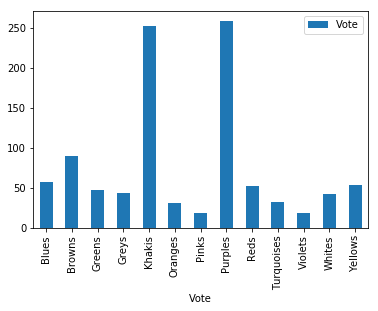

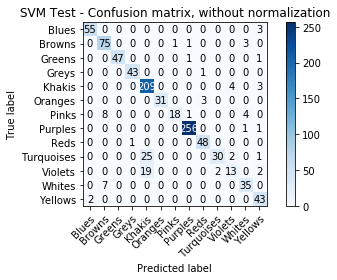

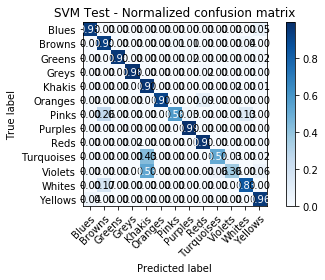

In [20]:
#########################
# Final Manual Decision #
#########################
print("Test Data on SVM")
#  X_train.append(X_validation)
svm_model = svm.SVC(kernel='rbf', gamma=1 / (X_train.columns.size * X_train.var().mean()), shrinking=True, probability=True, decision_function_shape='ovo')
svm_model.fit(X_train, y_train)
test_pred = svm_model.predict(X_test)
print(test_pred)
print(classification_report(y_test, test_pred))
# And the winner is--
df_predicted_labels = pd.DataFrame(data=test_pred, columns=['Vote'])

predicted_dist = df_predicted_labels.groupby(['Vote'])['Vote'].size().to_frame()
predicted_dist.plot(kind='bar')
plt.savefig('SVMTest-winner.png', bbox_inches='tight')

df_predicted_labels.to_csv('predicted_labels.csv', index=False, encoding='utf-8')
predicted_dist['Vote_pct(%)'] = 100 * predicted_dist.Vote / predicted_dist.Vote.sum()
print(predicted_dist)
# Calculate for transportation services
#svm_model.predict_log_proba(X_test)

# Confusion Matrix
class_names = np.unique(y_test.values)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_pred, classes=class_names,
                      title='SVM Test - Confusion matrix, without normalization')
plt.savefig('SVMTest-confusion matrix.png', bbox_inches='tight')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_pred, classes=class_names, normalize=True,
                      title='SVM Test - Normalized confusion matrix')
plt.savefig('SVMTest-Normalized confusion matrix.png', bbox_inches='tight')


# Load origin file
df = pd.read_csv('ElectionsData.csv')
print()
parties_by_percents = df['Vote'].value_counts(normalize=True) * 100
print("The division of voters between the various parties:")

In [32]:
prob = svm_model.predict_proba(X_test)
prob = pd.DataFrame(prob)
print(prob)

               0             1             2             3             4   \
0    3.562664e-04  9.147777e-01  9.627906e-04  3.942692e-04  3.167758e-04   
1    2.103874e-03  1.354877e-02  6.208048e-01  2.838403e-03  5.644662e-03   
2    2.257656e-05  9.880841e-01  6.361406e-05  3.070318e-04  3.451815e-05   
3    7.950844e-05  9.079748e-05  6.397100e-05  5.586936e-05  9.647013e-01   
4    1.899768e-03  8.271437e-04  2.588232e-04  9.744131e-04  1.153674e-03   
5    4.283495e-04  8.573784e-04  1.652425e-04  4.018925e-04  5.609912e-03   
6    7.428385e-05  7.049813e-05  2.843391e-05  7.528997e-05  9.531168e-01   
7    9.607357e-04  4.102848e-04  5.231553e-04  3.344448e-04  7.656165e-01   
8    4.025070e-05  1.365660e-04  2.423284e-04  1.268727e-04  6.342769e-02   
9    9.836649e-01  1.977356e-04  1.370533e-04  2.263475e-04  7.177877e-04   
10   1.033074e-04  4.598975e-05  4.032644e-05  3.372632e-05  9.826175e-01   
11   5.951560e-05  9.678438e-01  1.151063e-04  5.473424e-04  1.150516e-04   

In [52]:
from collections import defaultdict
import json
import csv

shuttles_by_parties = defaultdict(list)

for index, row in prob.iterrows():
    if row.max() > 0.5:
        shuttles_by_parties[test_pred[index]].append(index)

with open('shuttles_by_parties.csv', 'w') as f:
    writer = csv.writer(f)    
    for k,v in shuttles_by_parties.items():
        writer.writerow([k] + v)
        
# json.dump(shuttles_by_parties, open('shuttles_by_parties', 'w'))